In [2]:
import numpy as np
import pickle


In [3]:
N = 4
BOARD_ROWS = N
BOARD_COLS = N
BOARD_SIZE = BOARD_ROWS * BOARD_COLS


In [4]:
class State:
    def __init__(self):
        # the board is represented by an n * n array,
        # 1 represents a chessman of the player who moves first,
        # -1 represents a chessman of another player
        # 0 represents an empty position
        self.data = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.winner = None
        self.hash_val = None
        self.end = None

    # compute the hash value for one state, it's unique
    def hash(self):
        if self.hash_val is None:
            self.hash_val = 0
            for i in np.nditer(self.data):
                self.hash_val = self.hash_val * 3 + i + 1
        return self.hash_val

    # check whether a player has won the game, or it's a tie
    def is_end(self):
        if self.end is not None:
            return self.end
        results = []
        # check row
        for i in range(BOARD_ROWS):
            results.append(np.sum(self.data[i, :]))
        # check columns
        for i in range(BOARD_COLS):
            results.append(np.sum(self.data[:, i]))

        # check diagonals
        trace = 0
        reverse_trace = 0
        for i in range(BOARD_ROWS):
            trace += self.data[i, i]
            reverse_trace += self.data[i, BOARD_ROWS - 1 - i]
        results.append(trace)
        results.append(reverse_trace)

        for result in results:
            if result == N:
                self.winner = 1
                self.end = True
                return self.end
            if result == -N:
                self.winner = -1
                self.end = True
                return self.end

        # whether it's a tie
        sum_values = np.sum(np.abs(self.data))
        if sum_values == BOARD_SIZE:
            self.winner = 0
            self.end = True
            return self.end

        # game is still going on
        self.end = False
        return self.end

    # @symbol: 1 or -1
    # put chessman symbol in position (i, j)
    def next_state(self, i, j, symbol):
        new_state = State()
        new_state.data = np.copy(self.data)
        new_state.data[i, j] = symbol
        return new_state

    # print the board
    def print_state(self):
        for i in range(BOARD_ROWS):
            print('-----------------')
            out = '| '
            for j in range(BOARD_COLS):
                if self.data[i, j] == 1:
                    token = '*'
                elif self.data[i, j] == -1:
                    token = 'x'
                else:
                    token = '0'
                out += token + ' | '
            print(out)
        print('-----------------')



In [5]:
def get_all_states_impl(current_state, current_symbol, all_states):
    for i in range(BOARD_ROWS):
        for j in range(BOARD_COLS):
            if current_state.data[i][j] == 0:
                new_state = current_state.next_state(i, j, current_symbol)
                new_hash = new_state.hash()
                if new_hash not in all_states:
                    is_end = new_state.is_end()
                    all_states[new_hash] = (new_state, is_end)
                    if not is_end:
                        get_all_states_impl(new_state, -current_symbol, all_states)


def get_all_states():
    current_symbol = 1
    current_state = State()
    all_states = dict()
    all_states[current_state.hash()] = (current_state, current_state.is_end())
    get_all_states_impl(current_state, current_symbol, all_states)
    return all_states


# all possible board configurations
all_states = get_all_states()


In [6]:
class Judger:
    # @player1: the player who will move first, its chessman will be 1
    # @player2: another player with a chessman -1
    def __init__(self, player1, player2):
        self.p1 = player1
        self.p2 = player2
        self.current_player = None
        self.p1_symbol = 1
        self.p2_symbol = -1
        self.p1.set_symbol(self.p1_symbol)
        self.p2.set_symbol(self.p2_symbol)
        self.current_state = State()

    def reset(self):
        self.p1.reset()
        self.p2.reset()

    def alternate(self):
        while True:
            yield self.p1
            yield self.p2

    # @print_state: if True, print each board during the game
    def play(self, print_state=True):
        alternator = self.alternate()
        self.reset()
        current_state = State()
        self.p1.set_state(current_state)
        self.p2.set_state(current_state)
        if print_state:
            current_state.print_state()
        while True:
            player = next(alternator)
            i, j, symbol = player.act()
            next_state_hash = current_state.next_state(i, j, symbol).hash()
            current_state, is_end = all_states[next_state_hash]
            self.p1.set_state(current_state)
            self.p2.set_state(current_state)
            if print_state:
                current_state.print_state()
            if is_end:
                return current_state.winner



In [7]:
# AI player
class Player:
    # @step_size: the step size to update estimations
    # @epsilon: the probability to explore
    def __init__(self, step_size=0.1, epochs=int(1e5), policy='e-greedy', **kwargs):
        self.estimations = dict()
        self.step_size = step_size
        self.policy = policy
        self.states = []
        self.greedy = []
        self.symbol = 0
        self.epochs = epochs
        self.kwargs = kwargs
        self.N = np.zeros((N, N))

    def reset(self):
        self.states = []
        self.greedy = []

    def set_state(self, state):
        self.states.append(state)
        self.greedy.append(True)

    def set_symbol(self, symbol):
        self.symbol = symbol
        for hash_val in all_states:
            state, is_end = all_states[hash_val]
            if is_end:
                if state.winner == self.symbol:
                    self.estimations[hash_val] = 1.0
                elif state.winner == 0:
                    # we need to distinguish between a tie and a lose
                    self.estimations[hash_val] = 0.5
                else:
                    self.estimations[hash_val] = 0
            else:
                self.estimations[hash_val] = 0.5

    # update value estimation
    def backup(self):
        states = [state.hash() for state in self.states]

        for i in reversed(range(len(states) - 1)):
            state = states[i]
            # td_error = self.greedy[i] * (self.estimations[states[i + 1]] - self.estimations[state])
            td_error = self.estimations[states[i + 1]] - self.estimations[state]
    
            self.estimations[state] += self.step_size * td_error

    # choose an action based on the state
    def act(self):
        state = self.states[-1]
        next_states = []
        next_positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if state.data[i, j] == 0:
                    next_positions.append([i, j])
                    next_states.append(state.next_state(
                        i, j, self.symbol).hash())

        if self.policy == 'e-greedy':
            epsilon = self.kwargs['epsilon']
            if np.random.rand() < epsilon:
                action = next_positions[np.random.randint(len(next_positions))]
                action.append(self.symbol)
                self.greedy[-1] = False
                return action

            values = []
            for hash_val, pos in zip(next_states, next_positions):
                values.append((self.estimations[hash_val], pos))
            np.random.shuffle(values)
            values.sort(key=lambda x: x[0], reverse=True)
            action = values[0][1]
            action.append(self.symbol)
            return action

        elif self.policy == 'ucb':
            values = []
            c_ratio = self.kwargs['c_ratio']
            for hash_val, pos in zip(next_states, next_positions):
                visits = self.N[pos[0], pos[1]]
                # print(visits)
                exploration_bonus = c_ratio * np.sqrt(np.log(len(self.states) + 1) / (visits + 1e-5))
                values.append((self.estimations.get(hash_val, 0) + exploration_bonus, pos))

            values.sort(key=lambda x: x[0], reverse=True)
            action = values[0][1]
            action.append(self.symbol)
            self.N[action[0], action[1]] = self.N[action[0], action[1]] + 1
            return action

        elif self.policy == 'boltzmann':
            tau = self.kwargs['temperature']
            probabilities = [np.exp(self.estimations[hash_val] / tau) for hash_val in next_states]
            probabilities /= sum(probabilities)
            selected_index = np.random.choice(len(next_positions), p=probabilities)
            action = next_positions[selected_index]
            action.append(self.symbol)
            return action

        else:
            raise ValueError("Invalid strategy. Choose from 'epsilon-greedy', 'ucb', or 'boltzmann'")

    def save_policy(self):
        with open('policy_%s_%s_%d.bin' % ('first' if self.symbol == 1 else 'second', self.policy, self.epochs), 'wb') as f:
            pickle.dump(self.estimations, f)

    def load_policy(self):
        with open('policy_%s_%s_%d.bin' % ('first' if self.symbol == 1 else 'second', self.policy, self.epochs), 'rb') as f:
            self.estimations = pickle.load(f)



In [8]:
# human interface
# input a number to put a chessman
# | q | w | e |
# | a | s | d |
# | z | x | c |
class HumanPlayer:
    def __init__(self, **kwargs):
        self.symbol = None
        self.keys = ['q', 'w', 'e', 'a', 's', 'd', 'z', 'x', 'c']
        self.state = None

    def reset(self):
        pass

    def set_state(self, state):
        self.state = state

    def set_symbol(self, symbol):
        self.symbol = symbol

    def act(self):
        self.state.print_state()
        key = input("Input your position:")
        data = self.keys.index(key)
        i = data // BOARD_COLS
        j = data % BOARD_COLS
        return i, j, self.symbol


In [9]:
def train(epochs=int(1e5), print_every_n=500, policy='e-greedy', **kwargs):
    player1 = Player(epochs=epochs, policy=policy, **kwargs)
    player2 = Player(epochs=epochs, policy=policy, **kwargs)
    judger = Judger(player1, player2)
    player1_win = 0.0
    player2_win = 0.0
    for i in range(1, epochs + 1):
        winner = judger.play(print_state=False)
        if winner == 1:
            player1_win += 1
        if winner == -1:
            player2_win += 1
        if i % print_every_n == 0:
            print('Epoch %d, player 1 winrate: %.02f, player 2 winrate: %.02f' % (i, player1_win / i, player2_win / i))
        player1.backup()
        player2.backup()
        judger.reset()
    player1.save_policy()
    player2.save_policy()


In [10]:
def compete(turns, epochs1, epochs2, policy1, policy2, **kwargs):
    player1 = Player(epochs=epochs1, policy=policy1, **kwargs)
    player2 = Player(epochs=epochs2, policy=policy2, **kwargs)
    judger = Judger(player1, player2)
    player1.load_policy()
    player2.load_policy()
    player1_win = 0.0
    player2_win = 0.0
    for i in range(turns):
        print("------------- %s -------------" %("TURN "+str(i+1)))
        winner = judger.play()
        if winner == 1:
            player1_win += 1
        if winner == -1:
            player2_win += 1
        judger.reset()
    print('%d turns, player 1 win %.02f, player 2 win %.02f, tie %.02f'
          % (turns, player1_win / turns, player2_win / turns, (turns - player1_win - player2_win) / turns))


In [11]:
# The game is a zero sum game. If both players are playing with an optimal strategy, every game will end in a tie.
# So we test whether the AI can guarantee at least a tie if it goes second.
def play():
    while True:
        player1 = HumanPlayer()
        player2 = Player(epsilon=0)
        judger = Judger(player1, player2)
        player2.load_policy()
        winner = judger.play()
        if winner == player2.symbol:
            print("You lose!")
        elif winner == player1.symbol:
            print("You win!")
        else:
            print("It is a tie!")


## e-greedy

In [14]:
train(epochs=int(1e3), policy='e-greedy', epsilon=0.01)
train(epochs=int(1e4), policy='e-greedy', epsilon=0.01)
train(epochs=int(1e5), policy='e-greedy', epsilon=0.01)


Epoch 500, player 1 winrate: 0.51, player 2 winrate: 0.29
Epoch 1000, player 1 winrate: 0.53, player 2 winrate: 0.27
Epoch 500, player 1 winrate: 0.51, player 2 winrate: 0.29
Epoch 1000, player 1 winrate: 0.48, player 2 winrate: 0.25
Epoch 1500, player 1 winrate: 0.47, player 2 winrate: 0.21
Epoch 2000, player 1 winrate: 0.44, player 2 winrate: 0.20
Epoch 2500, player 1 winrate: 0.44, player 2 winrate: 0.21
Epoch 3000, player 1 winrate: 0.45, player 2 winrate: 0.22
Epoch 3500, player 1 winrate: 0.44, player 2 winrate: 0.21
Epoch 4000, player 1 winrate: 0.45, player 2 winrate: 0.22
Epoch 4500, player 1 winrate: 0.46, player 2 winrate: 0.21
Epoch 5000, player 1 winrate: 0.46, player 2 winrate: 0.21
Epoch 5500, player 1 winrate: 0.47, player 2 winrate: 0.22
Epoch 6000, player 1 winrate: 0.47, player 2 winrate: 0.22
Epoch 6500, player 1 winrate: 0.47, player 2 winrate: 0.22
Epoch 7000, player 1 winrate: 0.47, player 2 winrate: 0.22
Epoch 7500, player 1 winrate: 0.47, player 2 winrate: 0.23

In [23]:
compete(turns=(10), epochs1=int(1e3), epochs2=int(1e5), policy1='e-greedy', policy2='e-greedy', epsilon=0.01)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| x | 0 | 0 | x | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| x | 0 | 0 | x | 
-----------------
| * | 

In [24]:
compete(turns=(10), epochs1=int(1e3), epochs2=int(1e4), policy1='e-greedy', policy2='e-greedy', epsilon=0.01)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
| 0 | 0 | 0 | x | 
-----------------
-----------------
| 0 | * | 0 | * | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
| 0 | 

In [25]:
compete(turns=(10), epochs1=int(1e3), epochs2=int(1e3), policy1='e-greedy', policy2='e-greedy', epsilon=0.01)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | x | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | 0 | x | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | x | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | 0 | x | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | x | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| * | 

In [26]:
compete(turns=(10), epochs1=int(1e4), epochs2=int(1e3), policy1='e-greedy', policy2='e-greedy', epsilon=0.01)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | x | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | x | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | x | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| x | 0 | 0 | * | 
-----------------
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | * | x | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| x | 

In [27]:
compete(turns=(10), epochs1=int(1e4), epochs2=int(1e5), policy1='e-greedy', policy2='e-greedy', epsilon=0.01)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | x | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | x | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
-----------------
| 0 | x | 0 | x | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
-----------------
| 0 | x | * | x | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 

In [28]:
compete(turns=(10), epochs1=int(1e4), epochs2=int(1e4), policy1='e-greedy', policy2='e-greedy', epsilon=0.01)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | x | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | * | 0 | 
-----------------
| 0 | * | 0 | x | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 

In [29]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e3), policy1='e-greedy', policy2='e-greedy', epsilon=0.01)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | 

In [30]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e4), policy1='e-greedy', policy2='e-greedy', epsilon=0.01)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | * | * | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
| x | 

In [31]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e5), policy1='e-greedy', policy2='e-greedy', epsilon=0.01)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| * | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| * | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | x | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| * | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | x | 
-----------------
| x | 0 | 0 | * | 
-----------------
| 0 | 

## UCB

In [13]:
train(epochs=int(1e3), policy='ucb', c_ratio=0.2)
train(epochs=int(1e4), policy='ucb', c_ratio=0.2)
train(epochs=int(1e5), policy='ucb', c_ratio=0.2)


Epoch 500, player 1 winrate: 0.04, player 2 winrate: 0.01
Epoch 1000, player 1 winrate: 0.02, player 2 winrate: 0.01
Epoch 500, player 1 winrate: 0.04, player 2 winrate: 0.01
Epoch 1000, player 1 winrate: 0.02, player 2 winrate: 0.01
Epoch 1500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 2000, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 2500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 3000, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 3500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 4000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 4500, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 5000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 5500, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 6000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 6500, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 7000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 7500, player 1 winrate: 0.04, player 2 winrate: 0.02

In [33]:
compete(turns=(10), epochs1=int(1e3), epochs2=int(1e3), policy1='ucb', policy2='ucb', c_ratio=0.2)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
-----------------
| * | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
-----------------
| * | x | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
-----------------
| * | x | * | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 

In [32]:
compete(turns=(10), epochs1=int(1e3), epochs2=int(1e4), policy1='ucb', policy2='ucb', c_ratio=0.2)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
-----------------
| * | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
-----------------
| * | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | x | x | 0 | 
-----------------
-----------------
| * | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 

In [34]:
compete(turns=(10), epochs1=int(1e3), epochs2=int(1e5), policy1='ucb', policy2='ucb', c_ratio=0.2)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | * | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | x | 
-----------------
| 0 | x | * | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| * | 0 | 0 | x | 
-----------------
| 0 | x | * | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 

In [35]:
compete(turns=(10), epochs1=int(1e4), epochs2=int(1e3), policy1='ucb', policy2='ucb', c_ratio=0.2)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| * | 0 | x | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| * | 0 | x | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| * | 

In [36]:
compete(turns=(10), epochs1=int(1e4), epochs2=int(1e4), policy1='ucb', policy2='ucb', c_ratio=0.2)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| * | 0 | x | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| * | 0 | x | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| * | 

In [37]:
compete(turns=(10), epochs1=int(1e4), epochs2=int(1e5), policy1='ucb', policy2='ucb', c_ratio=0.2)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | * | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | x | 
-----------------
| 0 | x | * | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | x | 
-----------------
| 0 | x | * | 0 | 
-----------------
| 0 | * | * | 0 | 
-----------------
| 0 | 

In [38]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e3), policy1='ucb', policy2='ucb', c_ratio=0.2)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | * | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| x | x | 0 | 0 | 
-----------------
| 0 | 0 | * | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| x | x | * | 0 | 
-----------------
| 0 | 0 | * | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 

In [39]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e4), policy1='ucb', policy2='ucb', c_ratio=0.2)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| x | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| x | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| x | 0 | 0 | * | 
-----------------
| 0 | 

In [40]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e5), policy1='ucb', policy2='ucb', c_ratio=0.2)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | x | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | x | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | x | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
-----------------
| x | * | 0 | 0 | 
-----------------
| 0 | 0 | x | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 

## boltzmann

In [12]:
train(epochs=int(1e3), policy='boltzmann', temperature=1)
train(epochs=int(1e4), policy='boltzmann', temperature=1)
train(epochs=int(1e5), policy='boltzmann', temperature=1)


Epoch 500, player 1 winrate: 0.37, player 2 winrate: 0.32
Epoch 1000, player 1 winrate: 0.37, player 2 winrate: 0.30
Epoch 500, player 1 winrate: 0.37, player 2 winrate: 0.27
Epoch 1000, player 1 winrate: 0.36, player 2 winrate: 0.28
Epoch 1500, player 1 winrate: 0.36, player 2 winrate: 0.28
Epoch 2000, player 1 winrate: 0.36, player 2 winrate: 0.27
Epoch 2500, player 1 winrate: 0.36, player 2 winrate: 0.28
Epoch 3000, player 1 winrate: 0.37, player 2 winrate: 0.27
Epoch 3500, player 1 winrate: 0.37, player 2 winrate: 0.27
Epoch 4000, player 1 winrate: 0.37, player 2 winrate: 0.27
Epoch 4500, player 1 winrate: 0.37, player 2 winrate: 0.27
Epoch 5000, player 1 winrate: 0.37, player 2 winrate: 0.27
Epoch 5500, player 1 winrate: 0.37, player 2 winrate: 0.27
Epoch 6000, player 1 winrate: 0.36, player 2 winrate: 0.27
Epoch 6500, player 1 winrate: 0.36, player 2 winrate: 0.27
Epoch 7000, player 1 winrate: 0.37, player 2 winrate: 0.27
Epoch 7500, player 1 winrate: 0.37, player 2 winrate: 0.27

In [41]:
compete(turns=(10), epochs1=int(1e3), epochs2=int(1e3), policy1='boltzmann', policy2='boltzmann', temperature=1)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | * | 0 | x | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | * | 0 | x | 
-----------------
| * | 0 | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
| x | 

In [42]:
compete(turns=(10), epochs1=int(1e3), epochs2=int(1e4), policy1='boltzmann', policy2='boltzmann', temperature=1)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | x | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | x | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | x | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | x | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | x | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 

In [43]:
compete(turns=(10), epochs1=int(1e3), epochs2=int(1e5), policy1='boltzmann', policy2='boltzmann', temperature=1)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
| * | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
| * | 0 | 0 | 0 | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
| * | * | 0 | 0 | 
-----------------
| x | 

In [44]:
compete(turns=(10), epochs1=int(1e4), epochs2=int(1e3), policy1='boltzmann', policy2='boltzmann', temperature=1)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| * | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| * | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| x | x | 0 | 0 | 
-----------------
| * | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| x | x | * | 0 | 
-----------------
| * | * | 0 | 0 | 
-----------------
| 0 | 

In [45]:
compete(turns=(10), epochs1=int(1e4), epochs2=int(1e4), policy1='boltzmann', policy2='boltzmann', temperature=1)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | 0 | x | * | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | * | 
-----------------
| 0 | 0 | x | * | 
-----------------
| 0 | 

In [46]:
compete(turns=(10), epochs1=int(1e4), epochs2=int(1e5), policy1='boltzmann', policy2='boltzmann', temperature=1)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | * | x | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | * | x | 0 | 
-----------------
| 0 | 

In [47]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e3), policy1='boltzmann', policy2='boltzmann', temperature=1)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | x | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| x | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | x | 
-----------------
| 0 | 

In [48]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e4), policy1='boltzmann', policy2='boltzmann', temperature=1)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | * | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| x | 0 | * | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| x | 0 | * | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | 0 | 0 | 
-----------------
-----------------
| x | 0 | * | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | x | 0 | 0 | 
-----------------
-----------------
| x | 0 | * | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | 0 | 0 | 
-----------------
| * | 

In [49]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e5), policy1='boltzmann', policy2='boltzmann', temperature=1)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | * | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | * | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | x | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | * | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 

## 交叉对弈

In [222]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e5), policy1='e-greedy', policy2='ucb', epsilon=0.01, c_ratio=0.2)


------------- TURN 1 -------------
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | x | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | * | x | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| x | 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | * | x | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| x | 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | * | x | 0 | 
-------------
| 0 | 0 | * | 0 | 
-------------
-------------
| x | 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | * |

In [223]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e5), policy1='e-greedy', policy2='boltzmann', epsilon=0.01, temperature=1)


------------- TURN 1 -------------
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | x | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | * | x | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | * | x | x | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | 0 | * | 0 | 
-------------
| 0 | * | x | x | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | 0 | * | 0 | 
-------------
| 0 | * |

In [224]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e5), policy1='ucb', policy2='e-greedy', epsilon=0.01, c_ratio=0.2)


------------- TURN 1 -------------
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | 0 | x | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | 0 | 
-------------
| * | 0 | 0 | * | 
-------------
| 0 | 0 | x | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | 0 | 
-------------
| * | 0 | x | * | 
-------------
| 0 | 0 | x | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| * | 0 | 0 | 0 | 
-------------
| * | 0 | x | * | 
-------------
| 0 | 0 | x | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| * | 0 | 0 | 0 | 
-------------
| * | x | x | * | 
-------------
| 0 | 0 |

In [231]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e5), policy1='ucb', policy2='boltzmann', c_ratio=0.2, temperature=1)


------------- TURN 1 -------------
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | x | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | x | 0 | * | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | 0 | * | 
-------------
| 0 | x | 0 | * | 
-------------
| 0 | 0 | 0 | x | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| * | 0 | 0 | * | 
-------------
| 0 | x | 0 | * | 
-------------
| 0 | 0 | 0 | x | 
-------------
| 0 | 0 | 0 | 0 | 
-------------
-------------
| * | 0 | 0 | * | 
-------------
| 0 | x | 0 | * | 
-------------
| 0 | 0 |

In [16]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e5), policy1='boltzmann', policy2='e-greedy', epsilon=0.01, temperature=1)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
| 0 | x | 0 | x | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | * | 0 | 0 | 
-----------------
| * | * | 0 | 0 | 
-----------------
| 0 | x | 0 | x | 
-----------------
| 0 | 

In [18]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e5), policy1='boltzmann', policy2='ucb', temperature=1, c_ratio=0.2)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | x | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | x | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | 0 | * | 
-----------------
-----------------
| 0 | 0 | x | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | x | * | 
-----------------
-----------------
| 0 | 0 | x | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | 0 | 0 | 
-----------------
| * | 

In [19]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e5), policy1='boltzmann', policy2='boltzmann', temperature=1, c_ratio=0.2)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | * | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | * | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | * | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | x | 0 | x | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| * | 0 | * | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 

In [21]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e5), policy1='ucb', policy2='ucb', temperature=1, c_ratio=0.2)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | x | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | x | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | x | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | * | 0 | 0 | 
-----------------
-----------------
| x | * | 0 | 0 | 
-----------------
| 0 | 0 | x | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 

In [22]:
compete(turns=(10), epochs1=int(1e5), epochs2=int(1e5), policy1='e-greedy', policy2='e-greedy', epsilon=0.01)


------------- TURN 1 -------------
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| 0 | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| * | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| * | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | x | 
-----------------
| x | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 
-----------------
-----------------
| * | 0 | 0 | * | 
-----------------
| 0 | 0 | 0 | x | 
-----------------
| x | 0 | 0 | * | 
-----------------
| 0 | 

## 绘图

In [131]:
def train_fig(epochs=int(1e5), print_every_n=500, policy='e-greedy', **kwargs):
    player1 = Player(epochs=epochs, policy=policy, **kwargs)
    player2 = Player(epochs=epochs, policy=policy, **kwargs)
    judger = Judger(player1, player2)
    player1_win = 0.0
    player2_win = 0.0
    win1 = []
    win2 = []
    for i in range(1, epochs + 1):
        winner = judger.play(print_state=False)
        if winner == 1:
            player1_win += 1
        if winner == -1:
            player2_win += 1
        if i % print_every_n == 0:
            print('Epoch %d, player 1 winrate: %.02f, player 2 winrate: %.02f' % (i, player1_win / i, player2_win / i))
        player1.backup()
        player2.backup()
        judger.reset()
        win1.append(player1_win/i)
        win2.append(player2_win/i)
    # player1.save_policy()
    # player2.save_policy()
    return win1, win2


In [151]:
e_iter1, e_iter2 = train_fig(epochs=int(1e4), policy='e-greedy', epsilon=0.01)


Epoch 500, player 1 winrate: 0.50, player 2 winrate: 0.28
Epoch 1000, player 1 winrate: 0.51, player 2 winrate: 0.28
Epoch 1500, player 1 winrate: 0.49, player 2 winrate: 0.26
Epoch 2000, player 1 winrate: 0.50, player 2 winrate: 0.25
Epoch 2500, player 1 winrate: 0.45, player 2 winrate: 0.21
Epoch 3000, player 1 winrate: 0.40, player 2 winrate: 0.19
Epoch 3500, player 1 winrate: 0.40, player 2 winrate: 0.20
Epoch 4000, player 1 winrate: 0.40, player 2 winrate: 0.20
Epoch 4500, player 1 winrate: 0.39, player 2 winrate: 0.19
Epoch 5000, player 1 winrate: 0.39, player 2 winrate: 0.19
Epoch 5500, player 1 winrate: 0.39, player 2 winrate: 0.19
Epoch 6000, player 1 winrate: 0.40, player 2 winrate: 0.19
Epoch 6500, player 1 winrate: 0.40, player 2 winrate: 0.19
Epoch 7000, player 1 winrate: 0.40, player 2 winrate: 0.20
Epoch 7500, player 1 winrate: 0.40, player 2 winrate: 0.20
Epoch 8000, player 1 winrate: 0.40, player 2 winrate: 0.19
Epoch 8500, player 1 winrate: 0.40, player 2 winrate: 0.2

In [172]:
ucb_iter1, ucb_iter2 = train_fig(epochs=int(1e4), policy='ucb', c_ratio=0.2)


Epoch 500, player 1 winrate: 0.04, player 2 winrate: 0.01
Epoch 1000, player 1 winrate: 0.02, player 2 winrate: 0.01
Epoch 1500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 2000, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 2500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 3000, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 3500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 4000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 4500, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 5000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 5500, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 6000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 6500, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 7000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 7500, player 1 winrate: 0.04, player 2 winrate: 0.02
Epoch 8000, player 1 winrate: 0.06, player 2 winrate: 0.04
Epoch 8500, player 1 winrate: 0.09, player 2 winrate: 0.0

In [155]:
boltz1, boltz2 = train_fig(epochs=int(1e4), policy='boltzmann', temperature=1)


Epoch 500, player 1 winrate: 0.38, player 2 winrate: 0.27
Epoch 1000, player 1 winrate: 0.39, player 2 winrate: 0.26
Epoch 1500, player 1 winrate: 0.37, player 2 winrate: 0.28
Epoch 2000, player 1 winrate: 0.37, player 2 winrate: 0.28
Epoch 2500, player 1 winrate: 0.37, player 2 winrate: 0.29
Epoch 3000, player 1 winrate: 0.37, player 2 winrate: 0.28
Epoch 3500, player 1 winrate: 0.37, player 2 winrate: 0.28
Epoch 4000, player 1 winrate: 0.37, player 2 winrate: 0.28
Epoch 4500, player 1 winrate: 0.37, player 2 winrate: 0.28
Epoch 5000, player 1 winrate: 0.37, player 2 winrate: 0.28
Epoch 5500, player 1 winrate: 0.36, player 2 winrate: 0.28
Epoch 6000, player 1 winrate: 0.36, player 2 winrate: 0.28
Epoch 6500, player 1 winrate: 0.36, player 2 winrate: 0.28
Epoch 7000, player 1 winrate: 0.37, player 2 winrate: 0.28
Epoch 7500, player 1 winrate: 0.37, player 2 winrate: 0.28
Epoch 8000, player 1 winrate: 0.37, player 2 winrate: 0.28
Epoch 8500, player 1 winrate: 0.37, player 2 winrate: 0.2

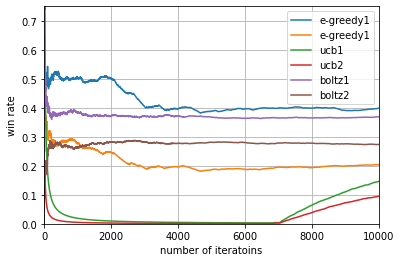

In [188]:
import matplotlib.pyplot as plt
plt.plot(e_iter1, label='e-greedy1')
plt.plot(e_iter2, label='e-greedy1')
plt.plot(ucb_iter1, label='ucb1')
plt.plot(ucb_iter2, label='ucb2')
plt.plot(boltz1, label='boltz1')
plt.plot(boltz2, label='boltz2')
plt.legend(loc='upper right')
plt.ylim(0, 0.75)
plt.xlim(0, 10000)
plt.xlabel('number of iteratoins')
plt.ylabel('win rate')
plt.grid(True)
plt.show()

In [190]:
ucb01, _ = train_fig(epochs=int(1e5), policy='ucb', c_ratio=0.1)


Epoch 500, player 1 winrate: 0.04, player 2 winrate: 0.01
Epoch 1000, player 1 winrate: 0.02, player 2 winrate: 0.01
Epoch 1500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 2000, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 2500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 3000, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 3500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 4000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 4500, player 1 winrate: 0.01, player 2 winrate: 0.01
Epoch 5000, player 1 winrate: 0.06, player 2 winrate: 0.04
Epoch 5500, player 1 winrate: 0.10, player 2 winrate: 0.06
Epoch 6000, player 1 winrate: 0.14, player 2 winrate: 0.08
Epoch 6500, player 1 winrate: 0.16, player 2 winrate: 0.09
Epoch 7000, player 1 winrate: 0.18, player 2 winrate: 0.11
Epoch 7500, player 1 winrate: 0.20, player 2 winrate: 0.12
Epoch 8000, player 1 winrate: 0.22, player 2 winrate: 0.13
Epoch 8500, player 1 winrate: 0.23, player 2 winrate: 0.1

In [191]:
ucb02, _ = train_fig(epochs=int(1e5), policy='ucb', c_ratio=0.2)


Epoch 500, player 1 winrate: 0.04, player 2 winrate: 0.01
Epoch 1000, player 1 winrate: 0.02, player 2 winrate: 0.01
Epoch 1500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 2000, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 2500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 3000, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 3500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 4000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 4500, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 5000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 5500, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 6000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 6500, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 7000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 7500, player 1 winrate: 0.04, player 2 winrate: 0.02
Epoch 8000, player 1 winrate: 0.06, player 2 winrate: 0.04
Epoch 8500, player 1 winrate: 0.09, player 2 winrate: 0.0

In [192]:
ucb05, _ = train_fig(epochs=int(1e5), policy='ucb', c_ratio=0.5)


Epoch 500, player 1 winrate: 0.04, player 2 winrate: 0.01
Epoch 1000, player 1 winrate: 0.02, player 2 winrate: 0.01
Epoch 1500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 2000, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 2500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 3000, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 3500, player 1 winrate: 0.01, player 2 winrate: 0.00
Epoch 4000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 4500, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 5000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 5500, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 6000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 6500, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 7000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 7500, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 8000, player 1 winrate: 0.00, player 2 winrate: 0.00
Epoch 8500, player 1 winrate: 0.00, player 2 winrate: 0.0

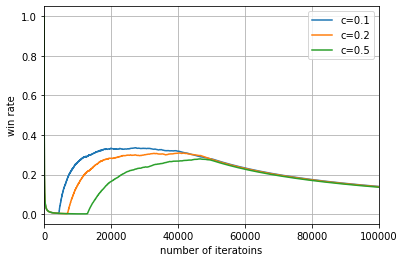

In [197]:
plt.plot(ucb01, label='c=0.1')
plt.plot(ucb02, label='c=0.2')
plt.plot(ucb05, label='c=0.5')
plt.legend(loc='upper right')
# plt.ylim(0, 0.75)
plt.xlim(0, 100000)
plt.xlabel('number of iteratoins')
plt.ylabel('win rate')
plt.grid(True)
plt.show()